In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import math
import utm
import numpy as np
import scipy.interpolate as spinterp
import csv

In [217]:
class belcher_morpher:
    
    def __init__(self):
        self._ngrid_lat_ = 73
        self._ngrid_long_ = 96
        self._file_ncolumn_ = 10
        self._lat_ = 37.67
        self._long_ = -122.12
        self._long_tz_ = -120
        
        self.f_pre = "HadCM3data/HADCM3_"
        self.f_year = "_2050"
        self.f_ext = ".dif"
        self.grid_list = [[22,64], [23,64], [21,64], [22,65]]
        self.grid_list_wind = [[21,64], [21,65], [22,64], [22,65]]
        
        table3_data = pd.read_csv("table/ASHRAE_table3.csv")
        self.pws_interp = spinterp.interp1d(np.array(table3_data["temperature"]), np.array(table3_data["pressure"]))
        kasten_data = pd.read_csv("table/Kasten1989_table2.csv")
        self.mk_interp = spinterp.interp1d(np.array(kasten_data["gamma"]), np.array(kasten_data["m"]))
        perez_data1 = pd.read_csv("table/perez1990_table4_eq6.csv")
        perez_data2 = pd.read_csv("table/perez1990_table4_eq7.csv")
        perez_data3 = pd.read_csv("table/perez1990_table4_eq8.csv")
        perez_data4 = pd.read_csv("table/perez1990_table4_eq10.csv")
        self.ai_ghi_interp = spinterp.interp1d(np.array(perez_data1["epsilon"]), np.array(perez_data1["a"]))
        self.bi_ghi_interp = spinterp.interp1d(np.array(perez_data1["epsilon"]), np.array(perez_data1["b"]))
        self.ci_ghi_interp = spinterp.interp1d(np.array(perez_data1["epsilon"]), np.array(perez_data1["c"]))
        self.di_ghi_interp = spinterp.interp1d(np.array(perez_data1["epsilon"]), np.array(perez_data1["d"]))
        self.ai_dni_interp = spinterp.interp1d(np.array(perez_data3["epsilon"]), np.array(perez_data3["a"]))
        self.bi_dni_interp = spinterp.interp1d(np.array(perez_data3["epsilon"]), np.array(perez_data3["b"]))
        self.ci_dni_interp = spinterp.interp1d(np.array(perez_data3["epsilon"]), np.array(perez_data3["c"]))
        self.di_dni_interp = spinterp.interp1d(np.array(perez_data3["epsilon"]), np.array(perez_data3["d"]))
        self.ai_dhi_interp = spinterp.interp1d(np.array(perez_data2["epsilon"]), np.array(perez_data2["a"]))
        self.bi_dhi_interp = spinterp.interp1d(np.array(perez_data2["epsilon"]), np.array(perez_data2["b"]))
        self.ci_dhi_interp = spinterp.interp1d(np.array(perez_data2["epsilon"]), np.array(perez_data2["c"]))
        self.di_dhi_interp = spinterp.interp1d(np.array(perez_data2["epsilon"]), np.array(perez_data2["d"]))
        self.ai_zl_interp = spinterp.interp1d(np.array(perez_data4["epsilon"]), np.array(perez_data4["a"]))
        self.bi_zl_interp = spinterp.interp1d(np.array(perez_data4["epsilon"]), np.array(perez_data4["b"]))
        self.ci_zl_interp = spinterp.interp1d(np.array(perez_data4["epsilon"]), np.array(perez_data4["c"]))
        self.di_zl_interp = spinterp.interp1d(np.array(perez_data4["epsilon"]), np.array(perez_data4["d"]))
        
    # Perez 1990, table 1    
    def sky_clearness_categories(self, epsilon):
        if epsilon < 1:
            #print("Error: epsilon is below lower bound")
            return 1
        elif epsilon < 1.065:
            return 1
        elif epsilon < 1.23:
            return 2
        elif epsilon < 1.5:
            return 3
        elif epsilon < 1.95:
            return 4
        elif epsilon < 2.8:
            return 5
        elif epsilon < 4.5:
            return 6
        elif epsilon < 6.2:
            return 7
        else:
            return 8
        
    def grid_to_file_pos(self, grid_lat, grid_long):
        n = (grid_lat-1)*self._ngrid_long_ + grid_long
        nrow = math.ceil(n/self._file_ncolumn_)
        ncol = n%self._file_ncolumn_
        if ncol == 0:
            ncol = self._file_ncolumn_
        return nrow-1, ncol-1

    def read_climate_file(self, filename, nl_header, grid_list, nrow_data):
        monthly_data = np.zeros((12,1))
        for month in range(0,12):
            read_data = pd.read_csv(filename, header=None, delim_whitespace=True, skiprows=nl_header+month*(nrow_data+nl_header), nrows=nrow_data)
            tmp_sum = 0
            count = 0
            for g in grid_list:
                nrow, ncol = self.grid_to_file_pos(g[0], g[1])
                tmp_sum += float(read_data.loc[nrow,ncol])
                count += 1
                #print(read_data.loc[nrow,ncol])
            monthly_data[month, 0] = tmp_sum / count
        return monthly_data

    def read_climate_file_relative(self, filename_dif, nl_header_dif, filename_mea, nl_header_mea, grid_list, nrow_data):
        monthly_data = np.zeros((12,1))
        for month in range(0,12):
            read_data_dif = pd.read_csv(filename_dif, header=None, delim_whitespace=True, skiprows=nl_header_dif+month*(nrow_data+nl_header_dif), nrows=nrow_data)
            read_data_mea = pd.read_csv(filename_mea, header=None, delim_whitespace=True, skiprows=nl_header_mea+month*(nrow_data+nl_header_mea), nrows=nrow_data)
            tmp_sum = 0
            count = 0
            for g in grid_list:
                nrow, ncol = self.grid_to_file_pos(g[0], g[1])
                tmp_sum += float(read_data_dif.loc[nrow,ncol]) / float(read_data_mea.loc[nrow,ncol]) * 100
                count += 1
                #print(read_data.loc[nrow,ncol])
            monthly_data[month, 0] = tmp_sum / count
        return monthly_data
    
    def read_HadCM3_data(self):
        # TEMP
        temp_A2a = self.read_climate_file(self.f_pre+"A2a_"+"TEMP"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        temp_A2b = self.read_climate_file(self.f_pre+"A2b_"+"TEMP"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        temp_A2c = self.read_climate_file(self.f_pre+"A2c_"+"TEMP"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        self.d_TEMP = np.mean((temp_A2a, temp_A2b, temp_A2c), axis=0)
        # TMAX
        tmax_A2a = self.read_climate_file(self.f_pre+"A2a_"+"TMAX"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        tmax_A2c = self.read_climate_file(self.f_pre+"A2c_"+"TMAX"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        self.d_TMAX = np.mean((tmax_A2a, tmax_A2c), axis=0)
        # TMIN
        tmin_A2a = self.read_climate_file(self.f_pre+"A2a_"+"TMIN"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        tmin_A2c = self.read_climate_file(self.f_pre+"A2c_"+"TMIN"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        self.d_TMIN = np.mean((tmin_A2a, tmin_A2c), axis=0)
        # DSWF
        dswf_A2a = self.read_climate_file(self.f_pre+"A2a_"+"DSWF"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        dswf_A2b = self.read_climate_file(self.f_pre+"A2b_"+"DSWF"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        dswf_A2c = self.read_climate_file(self.f_pre+"A2c_"+"DSWF"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        self.d_DSWF = np.mean((dswf_A2a, dswf_A2b, dswf_A2c), axis=0)
        # TCLW
        tclw_A2b = self.read_climate_file(self.f_pre+"A2b_"+"TCLW"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        tclw_A2c = self.read_climate_file(self.f_pre+"A2c_"+"TCLW"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        self.d_TCLW = np.mean((tclw_A2b, tclw_A2c), axis=0)
        # PREC
        prec_A2a = self.read_climate_file_relative(self.f_pre+"A2a_"+"PREC"+self.f_year+self.f_ext, 6, self.f_pre+"A2a_"+"PREC"+"_1980"+".mea", 5, self.grid_list, 701)
        prec_A2b = self.read_climate_file_relative(self.f_pre+"A2b_"+"PREC"+self.f_year+self.f_ext, 6, self.f_pre+"A2b_"+"PREC"+"_1980"+".mea", 5, self.grid_list, 701)
        prec_A2c = self.read_climate_file_relative(self.f_pre+"A2c_"+"PREC"+self.f_year+self.f_ext, 6, self.f_pre+"A2c_"+"PREC"+"_1980"+".mea", 5, self.grid_list, 701)
        self.d_PREC= np.mean((prec_A2a, prec_A2b, prec_A2c), axis=0)
        # RHUM
        rhum_A2a = self.read_climate_file(self.f_pre+"A2a_"+"RHUM"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        rhum_A2b = self.read_climate_file(self.f_pre+"A2b_"+"RHUM"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        rhum_A2c = self.read_climate_file(self.f_pre+"A2c_"+"RHUM"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        self.d_RHUM = np.mean((rhum_A2a, rhum_A2b, rhum_A2c), axis=0)
        # MSLP
        mslp_A2a = self.read_climate_file(self.f_pre+"A2a_"+"MSLP"+self.f_year+self.f_ext, 6, self.grid_list, 701)
        self.d_MSLP = mslp_A2a / 100
        # WIND
        wind_A2a = self.read_climate_file_relative(self.f_pre+"A2a_"+"WIND"+self.f_year+self.f_ext, 6, self.f_pre+"A2a_"+"WIND"+"_1980"+".mea", 5, self.grid_list_wind, 692)
        wind_A2b = self.read_climate_file_relative(self.f_pre+"A2b_"+"WIND"+self.f_year+self.f_ext, 6, self.f_pre+"A2b_"+"WIND"+"_1980"+".mea", 5, self.grid_list_wind, 692)
        wind_A2c = self.read_climate_file_relative(self.f_pre+"A2c_"+"WIND"+self.f_year+self.f_ext, 6, self.f_pre+"A2c_"+"WIND"+"_1980"+".mea", 5, self.grid_list_wind, 692)
        self.d_WIND = np.mean((wind_A2a, wind_A2b, wind_A2c), axis=0)
        
    def read_epw(self, filename, nl_header):
        read_data = pd.read_csv(filename, header=None, skiprows=nl_header)
        self.epw_data = read_data
        self.epw_dbt = np.reshape(np.array(read_data.loc[:,6]).astype(float), (read_data.shape[0], 1))
        self.epw_dpt = np.reshape(np.array(read_data.loc[:,7]).astype(float), (read_data.shape[0], 1))
        self.epw_rh = np.reshape(np.array(read_data.loc[:,8]).astype(float), (read_data.shape[0], 1))
        self.epw_ap = np.reshape(np.array(read_data.loc[:,9]).astype(float), (read_data.shape[0], 1))
        self.epw_ehr = np.reshape(np.array(read_data.loc[:,10]).astype(float), (read_data.shape[0], 1))
        self.epw_ednr = np.reshape(np.array(read_data.loc[:,11]).astype(float), (read_data.shape[0], 1))
        self.epw_hirfs = np.reshape(np.array(read_data.loc[:,12]).astype(float), (read_data.shape[0], 1))
        self.epw_ghr = np.reshape(np.array(read_data.loc[:,13]).astype(float), (read_data.shape[0], 1))
        self.epw_dnr = np.reshape(np.array(read_data.loc[:,14]).astype(float), (read_data.shape[0], 1))
        self.epw_dhr = np.reshape(np.array(read_data.loc[:,15]).astype(float), (read_data.shape[0], 1))
        self.epw_ghi = np.reshape(np.array(read_data.loc[:,16]).astype(float), (read_data.shape[0], 1))
        self.epw_dni = np.reshape(np.array(read_data.loc[:,17]).astype(float), (read_data.shape[0], 1))
        self.epw_dhi = np.reshape(np.array(read_data.loc[:,18]).astype(float), (read_data.shape[0], 1))
        self.epw_zl = np.reshape(np.array(read_data.loc[:,19]).astype(float), (read_data.shape[0], 1))
        self.epw_wd = np.reshape(np.array(read_data.loc[:,20]).astype(float), (read_data.shape[0], 1))
        self.epw_ws = np.reshape(np.array(read_data.loc[:,21]).astype(float), (read_data.shape[0], 1))
        self.epw_tsc = np.reshape(np.array(read_data.loc[:,22]).astype(float), (read_data.shape[0], 1))
        self.epw_osc = np.reshape(np.array(read_data.loc[:,23]).astype(float), (read_data.shape[0], 1))
        self.epw_precw = np.reshape(np.array(read_data.loc[:,28]).astype(float), (read_data.shape[0], 1))
        
        self.epw_header_1 = pd.read_csv(filename, header=None, nrows=1)
        self.epw_header_2 = pd.read_csv(filename, header=None, skiprows=3, nrows=1)
        self.epw_header_3 = pd.read_csv(filename, header=None, skiprows=7, nrows=1)
        
        n_depth = self.epw_header_2.loc[0,1]
        self.depth_arr = np. zeros((n_depth, 1))
        self.epw_gt_arr = np. zeros((n_depth, 12))
        for i in range(0, n_depth):
            self.depth_arr[i,0] = self.epw_header_2.loc[0,2+i*16]
            for j in range(0,12):
                self.epw_gt_arr[i,j] = self.epw_header_2.loc[0,6+i*16+j]
        
        
        
    def monthly_average(self, arr, time_unit):
        day_list = np.array([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365])
        avg = np.zeros((12,1))
        if time_unit == "h":
            day_list = day_list * 24
        for i in range(0, 12):
            count = 0
            tmp_sum = 0
            for j in range(day_list[i], day_list[i+1]):
                count += 1
                tmp_sum += arr[j,0]
            avg[i,0] = tmp_sum / count
        return avg
        
    def morphing(self):
        
        day_list = np.array([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365])
        day_list_h = day_list * 24
        
        # Dry bulb temperature
        dbt_m = self.monthly_average(self.epw_dbt,"h")
        dbt_max = np.max(self.epw_dbt.reshape(365,24), axis=1).reshape(365,1)
        dbt_min = np.min(self.epw_dbt.reshape(365,24), axis=1).reshape(365,1)
        dbt_max_m = self.monthly_average(dbt_max,"d")
        dbt_min_m = self.monthly_average(dbt_min,"d")
        alpha_dbt_m = (self.d_TMAX - self.d_TMIN) / (dbt_max_m - dbt_min_m)
        self.morph_dbt = np.zeros((365*24, 1))
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                self.morph_dbt[j,0] = self.epw_dbt[j,0] + self.d_TEMP[i,0] + alpha_dbt_m[i,0] * (self.epw_dbt[j,0] - dbt_m[i,0])
        
        # Dew point temperature and Relative humidity
        self.morph_dpt = np.zeros((365*24, 1))
        self.morph_rh = np.zeros((365*24, 1))
        pw = np.zeros((365*24, 1))
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                self.morph_rh[j,0] = self.epw_rh[j,0] + self.d_RHUM[i,0]
                pw[j,0] = self.morph_rh[j,0]/100 * self.pws_interp(self.morph_dbt[j,0])
                alpha = np.log(pw[j,0])
                if pw[j,0] < 0.61115:
                    self.morph_dpt[j,0] = 6.09 + 12.608*alpha + 0.4959*(alpha**2)
                else:
                    self.morph_dpt[j,0] = 6.54 + 14.526*alpha + 0.7389*(alpha**2) + 0.09486*(alpha**3) + 0.4569*(pw[j,0]**0.1984)
                
        # Atmospheric pressure
        self.morph_ap = np.zeros((365*24, 1))
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                self.morph_ap[j,0] = self.epw_ap[j,0] + self.d_MSLP[i,0]*100
                
        # Extraterrestrial horizontal radiation and Extraterrestrial direct normal radiation *?
        self.morph_ehr = np.zeros((365*24, 1))
        self.morph_ednr = np.zeros((365*24, 1))
        sin_gamma = np.zeros((365*24, 1))
        sot = np.zeros((365*24, 1))
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                day = math.ceil((j+1) / 24.0)
                day_ang = day * 360 / 365.25
                eot = -0.128 * np.sin((day_ang-2.8)*np.pi/180) - 0.165 * np.sin((2*day_ang+19.7)*np.pi/180)
                epsilon_d = 1 + 0.03344*np.cos((day_ang-2.8)*np.pi/180)
                self.morph_ednr[j,0] = 1367 * epsilon_d
                if self.epw_ednr[j,0] == 0:
                    self.morph_ednr[j,0] = 0
                elif j != 0 and j != 8759:
                    if self.epw_ednr[j-1,0] == 0:
                        self.morph_ednr[j,0] = self.morph_ednr[j,0] * self.epw_ednr[j,0]/self.epw_ednr[j+1,0]
                    elif self.epw_ednr[j+1,0] == 0:
                        self.morph_ednr[j,0] = self.morph_ednr[j,0] * self.epw_ednr[j,0]/self.epw_ednr[j-1,0]
                hour = (j+1-0.5)%24
                sot[j,0] = hour + (self._long_ - self._long_tz_)/15 + eot
                omega = 360/24 * (sot[j,0]-12)
                #delta_r = np.arcsin( 0.3978*np.sin( (day_ang - 1.4 + 0.0355*np.sin((day_ang-0.0489)*np.pi/180))*np.pi/180 ) )
                delta_r = np.arcsin( 0.3978*np.sin( (day_ang*np.pi/180 - 1.4 + 0.0355*np.sin((day_ang*np.pi/180-0.0489))) ) )
                sin_gamma[j,0] = np.sin(self._lat_*np.pi/180)*np.sin(delta_r) + np.cos(self._lat_*np.pi/180)*np.cos(delta_r)*np.cos(omega*np.pi/180)
                self.morph_ehr[j,0] = sin_gamma[j,0] * self.morph_ednr[j,0]
                #hour = (j+1)%24
                #if hour == 0:
                #    hour = 24
                #lst = hour - 1
                #ehr_sum = 0
                #for t in range(0, 60):
                #    sot[j,0] = lst + (self._long_ - self._long_tz_)/15 + eot
                #    omega = 360/24 * (sot[j,0]-12)
                #    delta_r = np.arcsin( 0.3978*np.sin( (day_ang - 1.4 + 0.0355*np.sin((day_ang-0.0489)*np.pi/180))*np.pi/180 ) )
                #    sin_gamma[j,0] = np.sin(self._lat_*np.pi/180)*np.sin(delta_r) + np.cos(self._lat_*np.pi/180)*np.cos(delta_r)*np.cos(omega*np.pi/180)
                #    ehr_sum += sin_gamma[j,0] * self.morph_ednr[j,0]
                #    lst += 1/60
                #self.morph_ehr[j,0] = ehr_sum / 60
                
        gamma = np.arcsin(sin_gamma)/np.pi*180
        #print(self.morph_ednr)
        #print(self.morph_ehr)
        #print(np.arcsin(sin_gamma)/np.pi*180)
        
          
        # Total sky cover and Opaque sky cover
        self.morph_tsc = np.zeros((365*24, 1))
        self.morph_osc = np.zeros((365*24, 1))
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                self.morph_tsc[j,0] = max(0, min(10, self.epw_tsc[j,0] + self.d_TCLW[i,0]*10))
                if self.epw_tsc[j,0] == 0:
                    self.morph_osc[j,0] = 0
                else:
                    self.morph_osc[j,0] = self.morph_tsc[j,0] * self.epw_osc[j,0] / self.epw_tsc[j,0]
        
        # Horizontal infrared radiation from the sky *?
        self.morph_hirfs = np.zeros((365*24, 1))
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                epsilon_c = 1.24 * ((pw[j,0] / (self.morph_dbt[j,0]+273.15))**(1/7))
                epsilon_at = self.morph_tsc[j,0]/10.0 + (1 - self.morph_tsc[j,0]/10.0) * epsilon_c
                self.morph_hirfs[j,0] = epsilon_at * 5.67*(10**(-8)) * ((self.morph_dbt[j,0]+273.15)**4)
                
        self.morph_tsc = np.rint(self.morph_tsc).astype(int)
        self.morph_osc = np.rint(self.morph_osc).astype(int)
                
        #print(self.morph_hirfs)
        
        
        # Global horizontal radiation
        self.morph_ghr = np.zeros((365*24, 1))
        ghr_m = self.monthly_average(self.epw_ghr,"h")
        alpha_i_m = 1 + self.d_DSWF / ghr_m
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                self.morph_ghr[j,0] = alpha_i_m[i,0] * self.epw_ghr[j,0]
        
        # Diffuse horizontal radiation
        self.morph_dhr = np.zeros((365*24, 1))
        ghr_dsum = np.sum(self.morph_ghr.reshape(365,24), axis=1).reshape(365,1)
        ehr_dsum = np.sum(self.morph_ehr.reshape(365,24), axis=1).reshape(365,1)
        kt_d = ghr_dsum / ehr_dsum
        kt_h = np.zeros((365*24, 1))
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                if self.morph_ehr[j,0] == 0:
                    kt_h[j,0] = 0
                else:
                    kt_h[j,0] = self.morph_ghr[j,0] / self.morph_ehr[j,0]
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                #self.morph_dhr[j,0] = alpha_i_m[i,0] * self.epw_dhr[j,0]
                if self.epw_ednr[j,0] == 0:
                    self.morph_dhr[j,0] = 0
                else:
                    if self.epw_ednr[j-1,0] == 0:
                        psi = kt_h[j+1,0]
                    elif self.epw_ednr[j+1,0] == 0:
                        psi = kt_h[j-1,0]
                    else:
                        psi = (kt_h[j+1,0] + kt_h[j-1,0]) / 2
                    self.morph_dhr[j,0] = self.morph_ghr[j,0] / (1 + np.exp(-5.38 + 6.63*kt_h[j,0] + 0.006*sot[j,0] - 0.007*gamma[j,0] + 1.75*kt_d[math.floor(j/24.0),0] + 1.31*psi))
                
        # Direct normal radiation
        self.morph_dnr = np.zeros((365*24, 1))
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                self.morph_dnr[j,0] = (self.morph_ghr[j,0] - self.morph_dhr[j,0]) / sin_gamma[j,0]
        
        
        # Global horizontal illuminance
        # Direct normal illuminance
        # Direct horizontal illuminance
        # Zenith luminance
        self.morph_ghi = np.zeros((365*24, 1))
        self.morph_dni = np.zeros((365*24, 1))
        self.morph_dhi = np.zeros((365*24, 1))
        self.morph_zl = np.zeros((365*24, 1))
        theta = (90 - gamma) * np.pi/180
        pwc = np.exp(0.07*self.morph_dpt - 0.075)
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                if self.epw_ednr[j,0] == 0 or gamma[j,0] < 0:
                    self.morph_ghi[j,0] = 0
                    self.morph_dni[j,0] = 0
                    self.morph_dhi[j,0] = 0
                    self.morph_zl[j,0] = 0
                else:
                    mk = self.mk_interp(gamma[j,0])
                    delta_ab = self.morph_dhr[j,0] * mk / self.morph_ednr[j,0]
                    epsilon_sc = ( (self.morph_dhr[j,0] + self.morph_dnr[j,0])/(self.morph_dhr[j,0] + 1.041*(theta[j,0]**3)) ) / (1 + 1.041*(theta[j,0]**3))
                    #print("epsilon_sc: ", epsilon_sc)
                    #print(j, delta_ab)
                    # *! delta_ab may be zero, need ln(delta_ab), how?
                    scc = self.sky_clearness_categories(epsilon_sc)
                    ai_ghi = self.ai_ghi_interp(scc)
                    bi_ghi = self.bi_ghi_interp(scc)
                    ci_ghi = self.ci_ghi_interp(scc)
                    di_ghi = self.di_ghi_interp(scc)
                    self.morph_ghi[j,0] = self.morph_ghr[j,0] * (ai_ghi + bi_ghi*pwc[j,0] + ci_ghi*np.cos(theta[j,0]) + di_ghi*np.log(delta_ab))
                    ai_dni = self.ai_dni_interp(scc)
                    bi_dni = self.bi_dni_interp(scc)
                    ci_dni = self.ci_dni_interp(scc)
                    di_dni = self.di_dni_interp(scc)
                    self.morph_dni[j,0] = max( 0, self.morph_dnr[j,0] * (ai_dni + bi_dni*pwc[j,0] + ci_dni*np.exp(5.73*theta[j,0]-5) + di_dni*delta_ab) )
                    ai_dhi = self.ai_dhi_interp(scc)
                    bi_dhi = self.bi_dhi_interp(scc)
                    ci_dhi = self.ci_dhi_interp(scc)
                    di_dhi = self.di_dhi_interp(scc)
                    self.morph_dhi[j,0] = self.morph_dhr[j,0] * (ai_dhi + bi_dhi*pwc[j,0] + ci_dhi*np.cos(theta[j,0]) + di_dhi*np.log(delta_ab))
                    ai_zl = self.ai_zl_interp(scc)
                    bi_zl = self.bi_zl_interp(scc)
                    ci_zl = self.ci_zl_interp(scc)
                    di_zl = self.di_zl_interp(scc)
                    self.morph_zl[j,0] = self.morph_dhr[j,0] * (ai_zl + bi_zl*np.cos(theta[j,0]) + ci_zl*np.exp(-3*theta[j,0]) + di_zl*delta_ab)
                    
        # Wind direction and Wind speed
        self.morph_wd = self.epw_wd
        self.morph_ws = np.zeros((365*24, 1))
        alpha_ws = 1 + self.d_WIND/100
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                self.morph_ws[j,0] = alpha_ws[i,0] * self.epw_ws[j,0]
                
        # Precipitable water
        self.morph_precw = np.zeros((365*24, 1))
        for i in range(0, 12):
            for j in range(day_list_h[i], day_list_h[i+1]):
                self.morph_precw[j,0] = self.epw_precw[j,0] * (1 + self.d_PREC[i,0]/100)
                
        # Ground temperature *?
        gtd = np.zeros((365, self.depth_arr.shape[0]))
        self.morph_gt = np.zeros((12, self.depth_arr.shape[0]))
        ds = 0.055741824
        d_shift = np.array([15,46,74,95,135,166,196,227,258,288,319,349])
        dbt_a = np.mean(self.morph_dbt)
        dbt_m = self.monthly_average(self.morph_dbt,"h")
        dbt_amp = max(dbt_m) - min(dbt_m)
        for d in range(0, self.depth_arr.shape[0]):
            x = self.depth_arr[d,0] * (np.pi/(ds*365))**0.5
            y = (np.exp(-x)**2 - 2*np.exp(-x)*np.cos(x) +1) / (2*x**2)
            z = (1 - np.exp(-x)*(np.cos(x)+np.sin(x))) / (1 - np.exp(-x)*(np.cos(x)-np.sin(x)))
            #print("x: ", x)
            #print("y: ", y)
            #print("z: ", z)
            for i in range(0, 12):
                for j in range(day_list[i], day_list[i+1]):
                    gtd[j,d] = dbt_a - dbt_amp*np.cos(2*j*np.pi/365 -(d_shift[i]*0.017214+0.341787) -np.arctan(z))*(y**0.5)
                    #print("cos: ", np.cos(2*j*np.pi/365 -(d_shift[i]*0.017214+0.341787) -np.arctan(z)))
            self.morph_gt[:,d] = np.ravel(self.monthly_average(np.reshape(gtd[:,d], (365,1)),"d"))
                    
        #print("dbt_a: ", dbt_a)
        #print("dbt_amp: ", dbt_amp)
        #print(self.morph_gt)
        
        
        return
    
    def write_morphed_epw(self):
        df_morph = pd.DataFrame(np.hstack(( \
                                     np.around(self.morph_dbt, decimals=1), \
                                     np.around(self.morph_dpt, decimals=1), \
                                     np.rint(self.morph_rh).astype(int), \
                                     np.rint(self.morph_ap).astype(int), \
                                     np.rint(self.morph_ehr).astype(int), \
                                     np.rint(self.morph_ednr).astype(int), \
                                     np.rint(self.morph_hirfs).astype(int), \
                                     np.rint(self.morph_ghr).astype(int), \
                                     np.rint(self.morph_dnr).astype(int), \
                                     np.rint(self.morph_dhr).astype(int), \
                                     np.rint(self.morph_ghi).astype(int), \
                                     np.rint(self.morph_dni).astype(int), \
                                     np.rint(self.morph_dhi).astype(int), \
                                     np.rint(self.morph_zl).astype(int), \
                                     np.rint(self.morph_wd).astype(int), \
                                     np.around(self.morph_ws, decimals=1), \
                                     np.rint(self.morph_tsc).astype(int), \
                                     np.rint(self.morph_osc).astype(int) \
                                    )))
        df = pd.DataFrame(pd.np.column_stack([\
                                              np.full((8760,1), self.f_year[1:len(self.f_year)]), \
                                              self.epw_data.loc[:,1:5], \
                                              df_morph, \
                                              self.epw_data.loc[:,24:27], \
                                              np.rint(self.morph_precw).astype(int), \
                                              self.epw_data.loc[:,29:34]\
                                             ]))
        df.loc[:,8:20] = df.loc[:,8:20].astype(int)
        df.loc[:,22:23] = df.loc[:,22:23].astype(int)
        df.loc[:,28] = df.loc[:,28].astype(int)
        
        h1s_n = self.epw_header_1.to_string(header=False, index=False, index_names=False).split('\n')
        h1s = [','.join(ele.split()) for ele in h1s_n][0]
        h3s_n = self.epw_header_3.to_string(header=False, index=False, index_names=False).split('\n')
        h3s = [','.join(ele.split()) for ele in h3s_n][0]
        
        h2s = 'GROUND TEMPERATURES,' + str(self.depth_arr.shape[0]) + ','
        for d in range(0, self.depth_arr.shape[0]):
            h2s = h2s + str(self.depth_arr[d,0]) + ',,,,'
            for i in range(0, self.morph_gt.shape[0]):
                h2s = h2s + str(np.around(self.morph_gt[i,d], decimals=2)) + ','
        h2s = h2s[0:(len(h2s)-1)]
        
        header = '\n'.join([h1s,
                          'DESIGN CONDITIONS, 0',
                          'TYPICAL/EXTREME PERIODS,0',
                          h2s,
                          'HOLIDAYS/DAYLIGHT SAVINGS,No,0,0,0',
                          'COMMENTS 1',
                          'COMMENTS 2',
                          h3s])
            
        with open('generated_weather.epw', 'w') as file:
            for line in header:
                file.write(line)
            df.to_csv(file)

In [218]:
bm = belcher_morpher()
bm.read_HadCM3_data()
bm.read_epw("epw/G0600010.epw", 8)

In [219]:
gamma = bm.morphing()
#print(gamma[0:48,:])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:372: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:372: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:382: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:382: RuntimeWarning: invalid value encountered in double_scalars


In [220]:
bm.write_morphed_epw()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:452: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


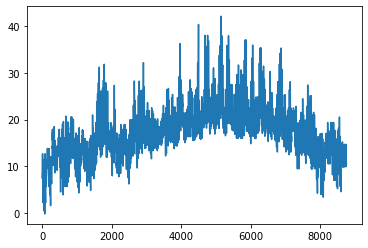

In [112]:
plt.plot(np.arange(0,8760), bm.morph_dbt)